In [1]:
#########
import torch
# import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import diffprivlib as dpl
import Other_Mean_Algs as OMA
import P_Trimed_Mean as PTA
from tqdm import tqdm
import itertools
import pickle
import os
import scipy.stats
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

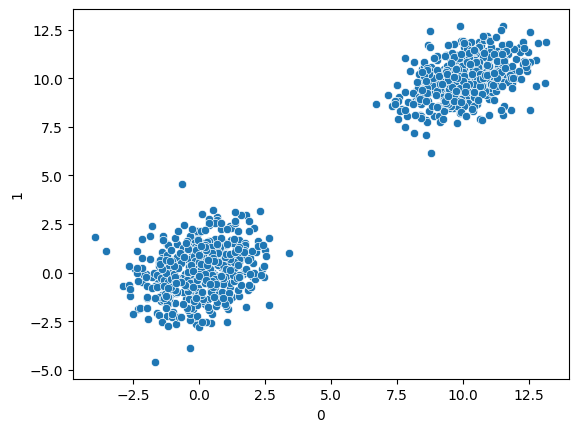

In [2]:
# This file compares splitting the privacy budget in numerous ways 
# n=1000
# d=4
# mix = torch.distributions.Categorical(torch.ones(2,))
#         # Stack the means and covariances to define the component distributions
# component_means = torch.stack([torch.zeros(d)-2,torch.zeros(d)+2])
# component_covariances = torch.stack([ get_cov(d), get_cov(d)])
# component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
# D = torch.distributions.MixtureSameFamily(mix, component_distributions)
# X=D.sample(torch.Size([n]))
# X

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(512, 512)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(512))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# get_cov(2).norm()
## Generate the datasets and set parameters
ns=[50,100,500,1000]
# ns=[50,100,200,300]
# rhos=[1,10,100]
rhos=[0.1,0.5,1]
Types=[1,2,3,4,5]
num_runs=250
# num_runs=100

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(d,d)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(d))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# Gen random data 
# 1. Normal, 2. Mixture, 3. Skew, 4. Heavy tail, 5. Contamination
def generate_data(Type,n,d,eta=0.2):
    if Type==1:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
    elif Type==2:
        mix = torch.distributions.Categorical(torch.ones(2,))
        # Stack the means and covariances to define the component distributions
        component_means = torch.stack([torch.zeros(d)-5,torch.zeros(d)+5])
        component_covariances = torch.stack([ get_cov(d), get_cov(d)])
        component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
        D = torch.distributions.MixtureSameFamily(mix, component_distributions)
        X=D.sample(torch.Size([n]))
    elif Type==3:
        D = torch.distributions.Exponential(torch.tensor([1.0]))
        X=D.sample(torch.Size((n,d)))-1
    elif Type==4:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
        A=D.sample((d,))
        D = torch.distributions.StudentT(df=3.0)
        X= D.sample(torch.Size((n,d))) @ A.t()
    else:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
        X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
        X=X[torch.randperm(n),:]
    return X


X=generate_data(2,1000,2,eta=0.2)+5
X=torch.squeeze(X)
df=pd.DataFrame(X)
df.head()
sns.scatterplot(data=df,x=0,y=1)
# plt.plot(X)

In [3]:
def one_run(n,d,rho,Type,seed=1):
    torch.manual_seed(seed)
    X=generate_data(Type,n,d,eta=0.2)+5
    sqrtd=np.sqrt(d)
    radius=50
    X=X.numpy()
    rng=np.random.default_rng(seed=seed)
    top=int(np.min((100,int(0.05*n))))
    constant=rng.integers(low=1, high=top, size=1)
    ## Private trimmed mean
    tm=PTA.private_tm_zCDP_mod_1(X, -radius,radius,3*rho/8,3*rho/8,rho/4,beta=1.001,constant=constant,eta=0,seed=seed)
    tm2=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0,seed=seed)
    tm3=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/8,rho/8,3*rho/4,beta=1.001,constant=constant,eta=0,seed=seed)
    return [tm,tm2,tm3]

rng=np.random.default_rng()
c=rng.integers(low=1, high=1000, size=1)
one_run(1000,1,5,1,c)

[4.990294954879807, 4.987586033955646, 4.985353444196991]

In [4]:
total=len(ns)*len(rhos)*5
count=0
for n in ns:
    print(count/total)
    for rho in rhos:
        for Type in range(5):
            mean_ests=[]
            file_name='output_1d/tm_mean_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
            if not os.path.exists(file_name):
            # if True:
                        # print(count/total)
                        # print('starting ',n,d,epsilon,Type)
                for i in range(num_runs):
                    mean_ests.append(one_run(n,1,rho,Type+1,seed=i+500))
                            # Pickling to a filen,d,rho,Type,constant,eta,seed=1
                    with open(file_name, 'wb') as file:
                        pickle.dump(mean_ests, file)                        
                        # print('completed ',n,d,epsilon,Type)
                    # else:
                    #     print("Skipped!")
                count+=1
                    
            else:
                count+=len(rhos)*5
            # print(count/total)

0.0
0.25
0.5
0.75


In [5]:
# Now analyze the output
# Make a Data frame, rows are n, d, eps, type , columns is the 4 different methods 
# [CoinPress, prime, tm, p_mom]
Types=[1,2,3,4,5]
# ns=ns[:-1]
def get_mse(n,rho,Type):
    if (rho==1):
         rho=int(rho)
    file_name='output_1d/tm_mean_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type-1)+'_nr_'+str(num_runs)+'.pkl'    
    # print(file_name)
    try:
        with open(file_name, 'rb') as file:
            mean_list = pickle.load(file)
        list_of_mse=[[np.full(1, np.nan) if y is None else y for y in x] for x in mean_list]
        list_of_mse=[[np.full(1, np.nan) if np.array_equal(y,np.ones(1)*-1000)  else y for y in x] for x in list_of_mse]
        list_of_mse=[((np.vstack(x)-5)**2) for x in list_of_mse]
        # list_of_mse[0].shape
        list_of_mse=[x.sum(axis=1) for x in list_of_mse]
        # list_of_mse[0].shape
        MSEs=[np.vstack(x) for x in list_of_mse]
        nans=np.mean(np.isnan(np.hstack(MSEs)),axis=1)
        if nans.sum()>0:
            file_name='output_1d/mean_comparison_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'.pkl'
            print(file_name+' ',str(nans))
        return np.nanmean(np.hstack(MSEs),axis=1)
    except:
        if n>1:
            print(file_name)
        a = np.empty(4)
        return a.fill(np.nan)

def get_mse_wrapper(x):
    # print(x['n'])
        return get_mse(int(x['n']),x['rho'],int(x['Type']))


combinations = list(itertools.product(ns, rhos,  Types))
results=pd.DataFrame(combinations, columns=['n', 'rho', 'Type'])

results
n=100
rho=1
Type=1

# results[['CP','TM']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results[['more to quantile','equal','more to mean']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')

# tm,tm_c,bun,duchi,kam]
# Melt the DataFrame to have two columns: 'MSE' and 'estimator'
results_melted = results.melt(id_vars=['n', 'rho', 'Type'], 
                              value_vars=['more to quantile','equal','more to mean'], 
                              var_name='estimator', 
                              value_name='MSE')

results_melted.head()

# 3*rho/8,3*rho/8,rho/4,beta=1.001,constant=constant,eta=0,seed=seed)
#     tm2=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0,seed=seed)
#     tm3=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/8,rho/8,3*rho/4,beta=1.001,constant=constant,eta=0,seed=seed)
 
results.columns=[r'$n$',r'$\rho$','Distribution','Quantile favored','Equal','Mean favored']


dists2={1: 'Gaussian',
       2: 'Gaussian Mix.',
       3: 'Skewed' ,
       4: 'Heavy Tails',
       5: 'Cont. Gaussian'}


results['Distribution']=results['Distribution'].map(dists2)
results.head()

for n in ns:
    tmp=results[results[r'$n$']==n]
    tmp.index=tmp['Distribution']
    tmp=tmp.drop(columns=[r'$n$','Distribution'])
    tmp=tmp.style.format(decimal='.', thousands='.', precision=4)
    latex_table =tmp.to_latex()
    print(latex_table)

\begin{tabular}{lrrrr}
 & $\rho$ & Quantile favored & Equal & Mean favored \\
Distribution &  &  &  &  \\
Gaussian & 0.1000 & 1.0724 & 3.2019 & 26.9747 \\
Gaussian Mix. & 0.1000 & 12.3804 & 18.1274 & 31.0007 \\
Skewed & 0.1000 & 0.5160 & 2.0156 & 28.2555 \\
Heavy Tails & 0.1000 & 0.7095 & 2.1220 & 25.6965 \\
Cont. Gaussian & 0.1000 & 4.4354 & 4.7744 & 30.4394 \\
Gaussian & 0.5000 & 0.0767 & 0.0527 & 0.0571 \\
Gaussian Mix. & 0.5000 & 1.0573 & 0.8350 & 3.5427 \\
Skewed & 0.5000 & 0.0441 & 0.0622 & 0.0654 \\
Heavy Tails & 0.5000 & 0.0781 & 0.0692 & 0.0669 \\
Cont. Gaussian & 0.5000 & 2.6438 & 1.9936 & 1.1525 \\
Gaussian & 1.0000 & 0.0358 & 0.0332 & 0.0334 \\
Gaussian Mix. & 1.0000 & 0.7170 & 0.6965 & 0.7507 \\
Skewed & 1.0000 & 0.0308 & 0.0293 & 0.0452 \\
Heavy Tails & 1.0000 & 0.0681 & 0.0496 & 0.0522 \\
Cont. Gaussian & 1.0000 & 3.4910 & 3.0430 & 1.9391 \\
\end{tabular}

\begin{tabular}{lrrrr}
 & $\rho$ & Quantile favored & Equal & Mean favored \\
Distribution &  &  &  &  \\
Gaussian &

In [6]:

# results2=pd.pivot_table(results,index=[r'$n$',r'$\rho$','Distribution',r'$C$'],values='MSE',columns=r'$\eta$').reset_index()
# # results2=results2.rename_axis(None, axis=1)
# # results2=results2.rename_axis(None, axis=0)
# results2['Distribution']=results2['Distribution'].map(dists2)
# # results2=results2.drop(r'$\eta$')
# # results2[0.0].head()
# results2.head()
# # print(results2.columns.name)
# results2.columns=[tup for tup in list(results2.columns.to_flat_index())]
# results2.head()
# results2.columns=['$n$', '$\rho$', 'Distribution',r'$C$']+[r'$\eta$='+str(x) for x in [0.0, 0.025, 0.05, 0.15]]
# results2.head()

In [7]:
results_melted['lMSE']=np.log(results_melted['MSE'])
results_melted.head()
results_melted[results_melted['rho']==1].head()

,n,rho,Type,estimator,MSE,lMSE
10,50,1.0,1,more to quantile,0.035755,-3.331071
11,50,1.0,2,more to quantile,0.717012,-0.332662
12,50,1.0,3,more to quantile,0.030803,-3.480135
13,50,1.0,4,more to quantile,0.068083,-2.687029
14,50,1.0,5,more to quantile,3.490994,1.250187


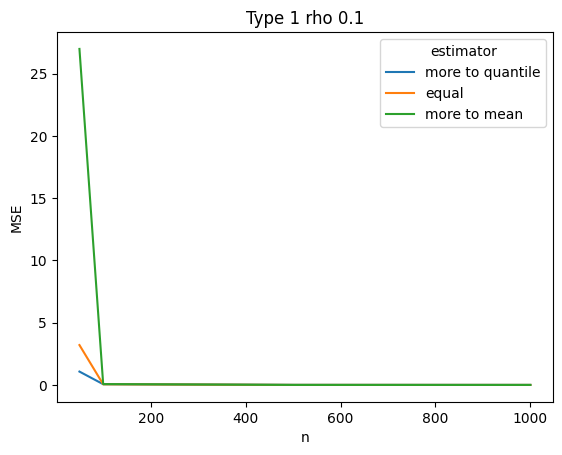

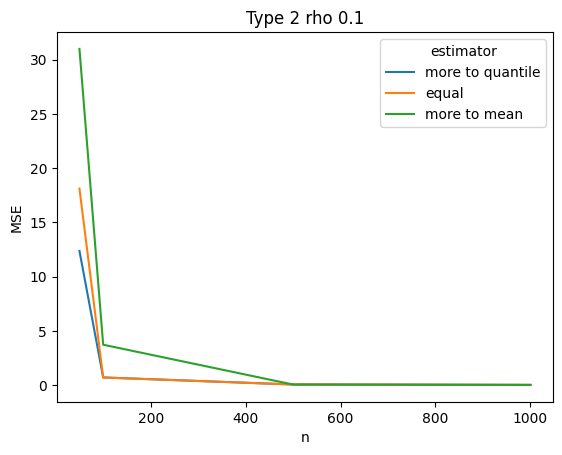

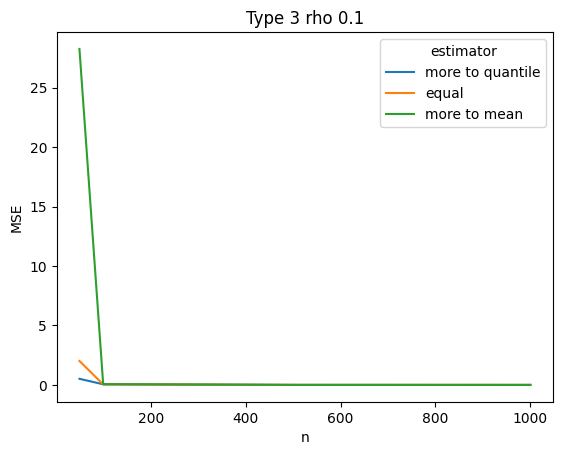

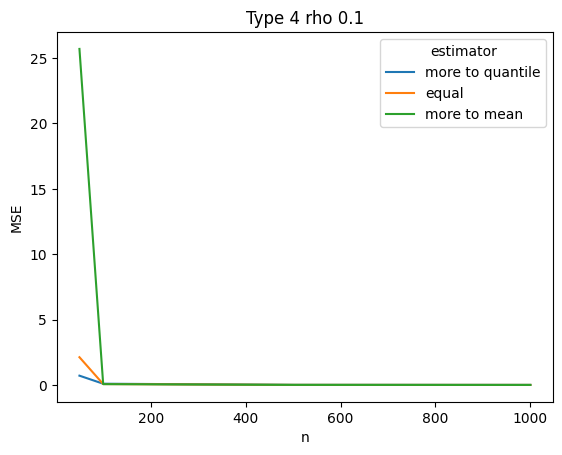

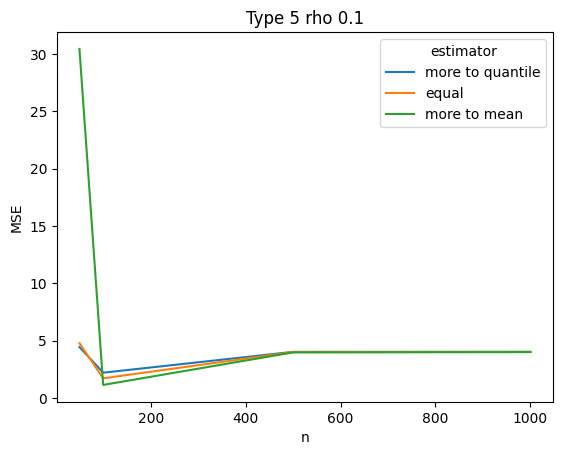

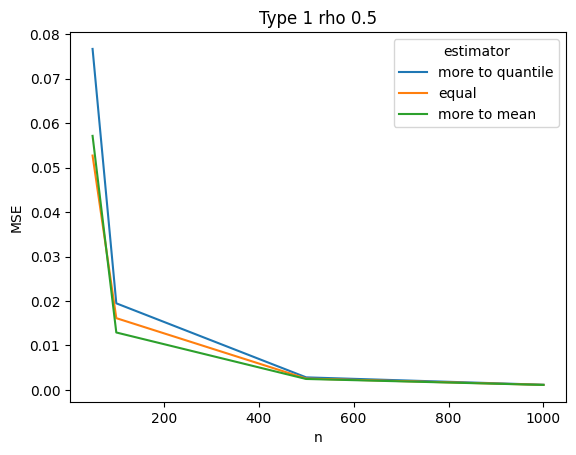

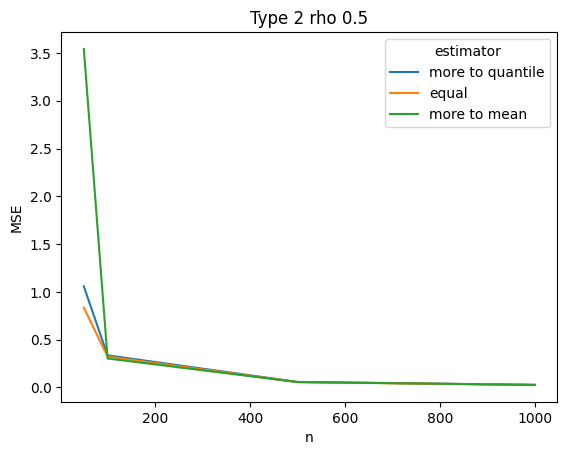

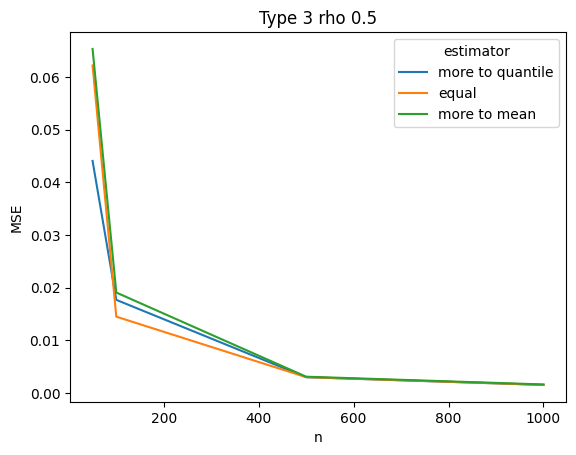

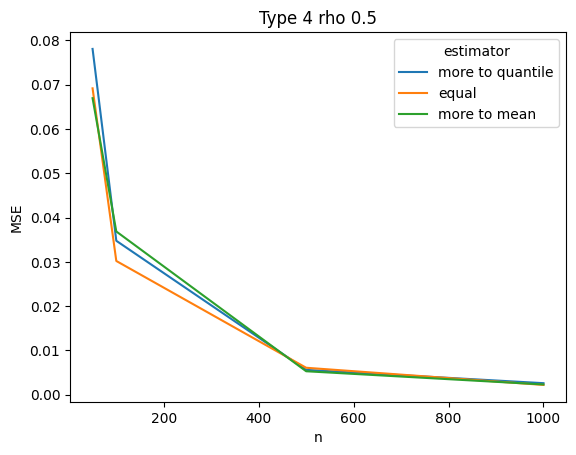

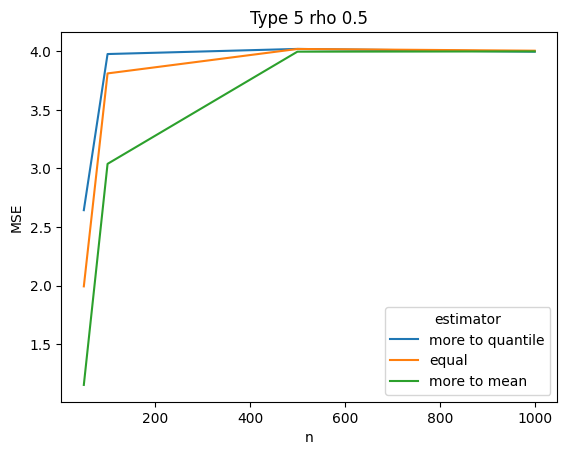

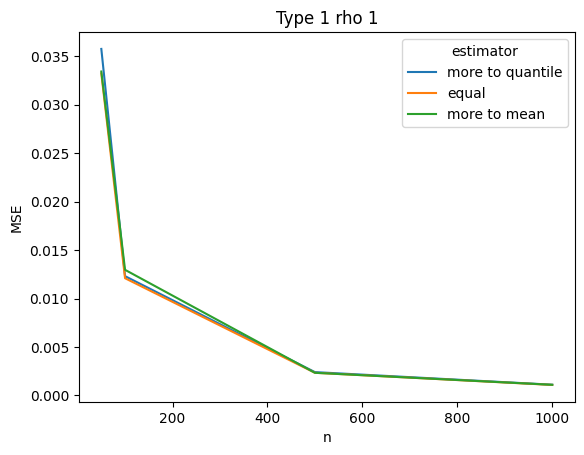

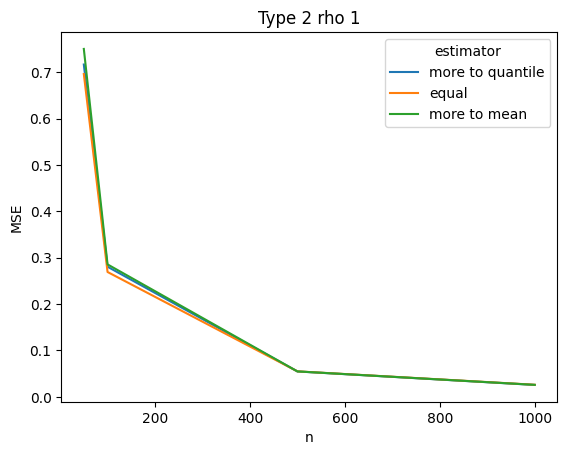

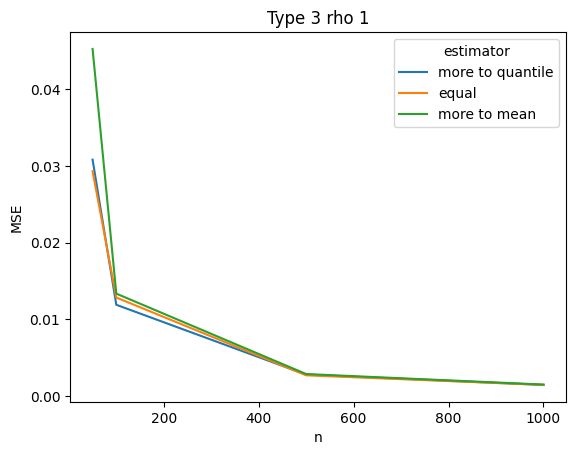

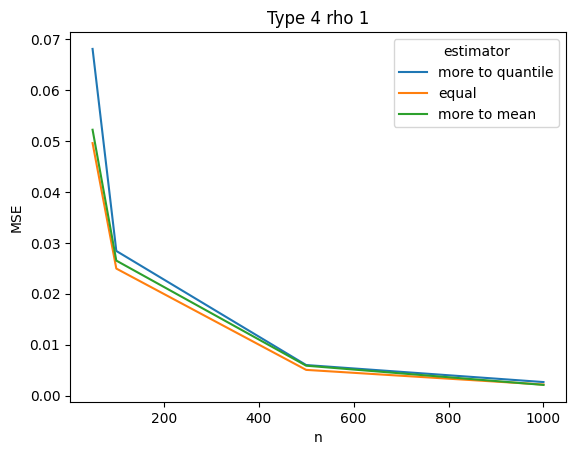

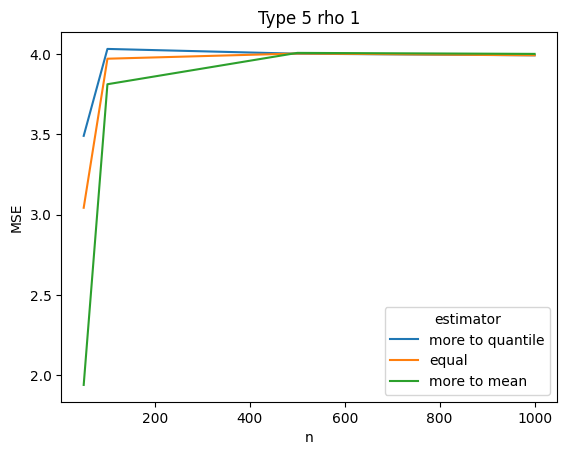

In [8]:


# now turn 4 columns into 1 
def make_plot(Type,rho,main):
    tmp=results_melted[results_melted['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='MSE',x='n',hue='estimator')
    plt.title(main)
    plt.show()

for rho in rhos:
    for i in Types:
        make_plot(i,rho,main='Type '+str(i)+' rho '+str(rho))